In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from itertools import product

In [3]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [4]:
sns.set()

In [5]:
url = "https://raw.githubusercontent.com/nadya27oct/Dairy-Sales/main/dairy_sales.csv"
raw = pd.read_csv(url)

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7646 entries, 0 to 7645
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             7646 non-null   object 
 1   upc              7646 non-null   int64  
 2   description      7646 non-null   object 
 3   quantity_sold    7646 non-null   float64
 4   price            7644 non-null   float64
 5   unit_cost        7611 non-null   float64
 6   _size            7258 non-null   object 
 7   unit_of_measure  5901 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 478.0+ KB


In [7]:
raw.head()

,date,upc,description,quantity_sold,price,unit_cost,_size,unit_of_measure
0,2021-01-01,74236526425,hrzn milk 2% uht og2,1.0,6.99,4.00,64,ea
1,2021-01-01,74236526402,hrzn milk lactose free,1.0,6.99,5.39,64 OZ,OZ
2,2021-01-01,2640041035,drgld bulgarian bttrmilk,1.0,2.99,1.36,NaN,NaN
3,2021-01-01,4190007641,dairy pure whole milk 64 z,8.0,2.99,2.33,64 Z,oz
4,2021-01-01,4190007663,viva 1/2 gal 2% milk,3.0,2.99,2.26,64,NaN


In [8]:
raw['unit_of_measure'].unique()

array(['ea', 'OZ', nan, 'oz', 'PK'], dtype=object)

In [9]:
raw['_size'].unique()

array(['64', '64 OZ', nan, '64 Z', '48', 'OZ', '52', '14 OZ', '12', '8',
       '32 OZ', '32', '128', '14', '16 OZ', '8 OZ', '1', '16', '12 OZ',
       '28', '28 OZ', '64OZ', 'GALLON', '48 OZ', '6 OZ'], dtype=object)

## Explaratory Data Analysis

In [10]:
def extract_numeric_weight(size_col):
    """
    Converting size column to a more meaningful numeric variable, ex:'GALLON' to 128
    """
    size = size_col.split()[0]
    
    if size == 'GALLON':
        size = '128'
    elif size == '64OZ':
        size = '64'
    elif size == 'OZ':
        size = 'undefined'
    
    return size
raw['size'] = raw['_size'].dropna().apply(extract_numeric_weight)
raw['size'] = raw['size'].fillna('undefined')

In [11]:
raw['size'].unique()

array(['64', 'undefined', '48', '52', '14', '12', '8', '32', '128', '16',
       '1', '28', '6'], dtype=object)

In [12]:
raw['revenue'] = raw['quantity_sold'] * raw['price']
raw['profit'] = raw['quantity_sold'] * (raw['price'] - raw['unit_cost'])

In [13]:
sales_by_size = (
    raw.groupby('size').agg({'quantity_sold':sum,
                             'upc': 'nunique',
                             'profit': sum,
                             'price':'mean'})
                       .reset_index()
        )    
sales_by_size['margin_per_unit'] = round(sales_by_size['profit']/sales_by_size['quantity_sold'],2)

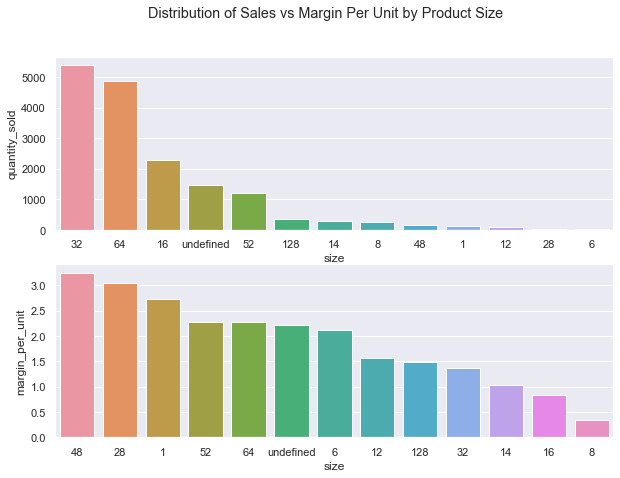

In [14]:
sales_order = sales_by_size.sort_values('quantity_sold',ascending=False)['size']
margin_order = sales_by_size.sort_values('margin_per_unit',ascending=False)['size']


fig,axes = plt.subplots(2,1,figsize=(10,7))
sns.barplot(data=sales_by_size, x='size',y='quantity_sold', ax=axes[0],order=sales_order)
sns.barplot(data=sales_by_size, x='size',y='margin_per_unit', ax=axes[1],order=margin_order)
plt.suptitle("Distribution of Sales vs Margin Per Unit by Product Size")
plt.show()

### Quantity Sold vs per Unit Margin

Items that weighed 32 and 64 drive the most volume of sales. <br> However, most of the higher margins are driven by products with a low sales volume. Products that weigh 48 and 28 oz have a low volume of sales but drive a higher margin per unit. <br>
After exploring their descriptions, these dairy products typically belong to a specific brand such as Fairlife or califia milk. <br>
Some low volume high margin items belong to a alternative milk products such as Oat milk.

In [15]:
# Same visualization as above using plotly
#fig = px.bar(sales_by_size,x='size',y='quantity_sold',barmode='group',width=800,height=400)
#fig.update_layout(xaxis={'categoryorder':'total descending'})

In [16]:
print(raw[raw['size']=='48']['description'].unique())
print(raw[raw['size']=='28']['description'].unique())
print(raw[raw['size']=='52']['description'].unique())

['califa oat milk unswtnd' 'califia go coconuts milk water'
 'ripple nd kids milk orig']
['malk almond milk vanilla' 'prms lnd whl milk ch']
['fa!rlife hole milk' 'fairlife 2% rf milk' 'fairlife 2% choc milk'
 'fairlife fat fr milk']


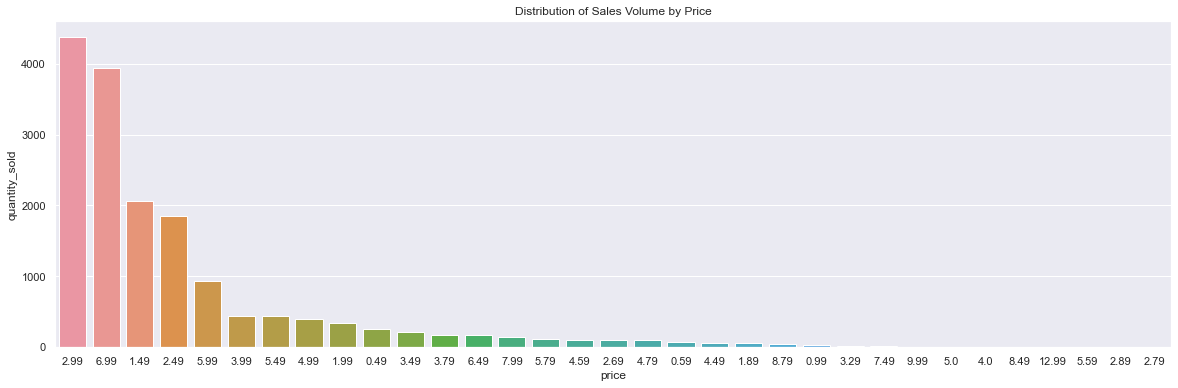

In [17]:
sales_by_price = raw.groupby('price').agg({'quantity_sold':sum}).reset_index()
order = sales_by_price.sort_values('quantity_sold',ascending=False)['price']

plt.figure(figsize=(20,6))
sns.barplot(data=sales_by_price,x='price',y='quantity_sold',order=order)
plt.title("Distribution of Sales Volume by Price")
plt.show()

We expect to see lower priced items bought more than higher priced dairy. While this is true, dairy items that cost $6.99 which is at the higher end for a dairy product contribute to a large portion of sales.

#### Create Date Related Variables to explore patterns

In [18]:
raw['date'] = pd.to_datetime(raw['date'])

raw['month'] = raw['date'].dt.month
raw['week'] = raw['date'].dt.isocalendar().week
raw['year'] = raw['date'].dt.year
raw['weekday'] = raw['date'].dt.strftime("%a")

raw['day_num'] = raw['date'].apply(lambda date: date.weekday())

raw['day_of_month'] = raw['date'].dt.day
raw['end_of_week'] = raw['date'].apply(lambda date: date + dt.timedelta(days=6 - date.weekday()))


raw['day_of_year'] = raw.date.dt.dayofyear

In [19]:
raw.sample(3)

,date,upc,description,quantity_sold,price,unit_cost,_size,unit_of_measure,size,revenue,profit,month,week,year,weekday,day_num,day_of_month,end_of_week,day_of_year
3968,2021-12-22,19064664101,oatly oat milk original,1.0,6.99,4.11,OZ,NaN,undefined,6.99,2.88,12,51,2021,Wed,2,22,2021-12-26,356
6683,2022-08-11,1570016453,mg vitamin d milk pint,6.0,1.49,0.82,16,OZ,16,8.94,4.02,8,32,2022,Thu,3,11,2022-08-14,223
6257,2022-07-10,2800077212,nesquick choc milk,4.0,2.69,1.36,14,oz,14,10.76,5.32,7,27,2022,Sun,6,10,2022-07-10,191


In [20]:
raw[(raw['week']==53) & (raw['year']==2021)]['date'].value_counts()

2021-01-03    11
2021-01-02    10
2021-01-01     7
Name: date, dtype: int64

In [21]:
raw[(raw['week']==52) & (raw['year']==2022)]['date'].value_counts()

2022-01-02    15
2022-01-01    10
Name: date, dtype: int64

2021-01-01 through 2021-01-03 belong to week 53 of 2020. <br> 
2022-01-01 through 2022-01-02 belongs to week 52 of 2021.<br>
We can keep this week-year-date mismatch as they are. But I will modify these weeks to be week 0 so that it is less confusing to analyze.

In [22]:
def update_end_weeks(cols):
    
    week = cols[0]
    year = cols[1]
    
    if year == 2021 and week == 53:
        return 0
    elif year == 2022 and week == 52:
        return 0
    else:
        return week

raw['week'] = raw[['week','year']].apply(update_end_weeks,axis=1)

#### Exploring Outliers

In [23]:
px.box(raw,x='unit_cost',width=900,
       height=400,title="Distribution of Unit Cost")

Majority of items cost between 1.39 and 3.72. But the box plot shows an outlier product that costs $14 belong to UPC - 4190007663 - 'viva 1/2 gal 2% milk'. <br>
Potential data error as this product cost changes from 2.26 to 14.13 and back to 1.45 within 4 days.<br>
I can overwrite this outlier using median, however, since I do not know the context to unit cost (whether it includes cost of ordering or cost of inventory holding), I will keep the value as it is. <br>

In [24]:
raw[raw['upc']==4190007663].head(4)

,date,upc,description,quantity_sold,price,unit_cost,_size,unit_of_measure,size,revenue,profit,month,week,year,weekday,day_num,day_of_month,end_of_week,day_of_year
4,2021-01-01,4190007663,viva 1/2 gal 2% milk,3.0,2.99,2.26,64,NaN,64,8.97,2.19,1,0,2021,Fri,4,1,2021-01-03,1
25,2021-01-03,4190007663,viva 1/2 gal 2% milk,3.0,2.99,14.13,64,NaN,64,8.97,-33.42,1,0,2021,Sun,6,3,2021-01-03,3
34,2021-01-04,4190007663,viva 1/2 gal 2% milk,1.0,2.99,1.45,64,NaN,64,2.99,1.54,1,1,2021,Mon,0,4,2021-01-10,4
43,2021-01-05,4190007663,viva 1/2 gal 2% milk,3.0,2.99,1.45,64,NaN,64,8.97,4.62,1,1,2021,Tue,1,5,2021-01-10,5


In [25]:
px.line(raw,y='quantity_sold',x='date',color='upc',
       title="Distribution of Sales per Product")

Another potential outlier with upc 1570010320 that recorded 32 units of sales on June 21st, 2021.<br>
While it is not uncommon for a store to sell 32 units of a certain milk product within a day, daily sales in neighboring weeks seem to be signficantly lower than 32 units.

In [26]:
raw[(raw['upc']==1570010320) & (raw['month']==6)][11:16]

,date,upc,description,quantity_sold,price,unit_cost,_size,unit_of_measure,size,revenue,profit,month,week,year,weekday,day_num,day_of_month,end_of_week,day_of_year
1550,2021-06-19,1570010320,mg buttermilk,1.0,0.49,0.27,8,OZ,8,0.49,0.22,6,24,2021,Sat,5,19,2021-06-20,170
1565,2021-06-20,1570010320,mg buttermilk,1.0,0.49,0.27,8,OZ,8,0.49,0.22,6,24,2021,Sun,6,20,2021-06-20,171
1584,2021-06-21,1570010320,mg buttermilk,32.0,0.49,0.27,8,OZ,8,15.68,7.04,6,25,2021,Mon,0,21,2021-06-27,172
1602,2021-06-22,1570010320,mg buttermilk,5.0,0.49,0.27,8,OZ,8,2.45,1.10,6,25,2021,Tue,1,22,2021-06-27,173
1633,2021-06-24,1570010320,mg buttermilk,1.0,0.49,0.27,8,OZ,8,0.49,0.22,6,25,2021,Thu,3,24,2021-06-27,175


In [27]:
daily_activity = (
    raw.groupby('date').agg(sku_count=('upc','count'),
                           sales_quantity=('quantity_sold',sum),
                            retail_dollars=('revenue',sum),
                            margin=('profit',sum))
                .asfreq('d')
                .fillna(0)
                                   )

In [28]:
px.line(daily_activity,y='sales_quantity',title='Time Series Weekly Sales for Dairy')

We can see some kind of a seasonality pattern based on time series data. But this pattern is not clear.<br>
For months Jan through June, we can see a seasonal pattern where sales dip in February and May, picking up again in end of March and June.<br>
Sales also increase in summer months compared to the rest of the year.

In [29]:
monthly = raw.groupby(['month','year']).agg({'quantity_sold':sum}).reset_index()

In [30]:
px.line(monthly,x='month',color='year',y='quantity_sold',
        title='Time Series Sales Aggregated at Month/Year')

No visible seasonality or trend here. Large jump of sales in June and July of both years and a decline in September and October.<br>
Small jump in sales in March and a decreasing trend in February and April.<br>
Interesting to explore why 2022 summer months experience a decline in sales compared to 2021.

In [31]:
subplot_day = (
    raw[raw['quantity_sold']<30].groupby(['day_of_month','month'])
                                .agg({'quantity_sold':sum,'year':'nunique'})
                                .reset_index()
                )
subplot_day['daily_average'] = subplot_day['quantity_sold']/subplot_day['year']

In [32]:
px.line(subplot_day,x='day_of_month',y='daily_average',facet_col='month',facet_col_wrap=3,
        width=1000,height=1500,title='Daily Sales for each month Averaged by Year')

After removing the outlier of 32 units sales, there is no inherent patterns on any given day. There are lots of ups and downs in each month. Some months observe a sales uptick occuring every other day. This is somewhat expected as milk have a shorter shelf life and is one of high velocity grocery items. <br> 
Beginning of the year, daily sales average at about 12 to 25 units.<br>
Summer months typically have a higher daily sales ranging from about 30 to 60 units. 

In [33]:
px.box(raw.groupby(['weekday','month']).agg({'quantity_sold':sum}).reset_index(),
        x='weekday',y='quantity_sold',height=400,width=800,
       category_orders={'weekday':['Mon','Tue','Wed','Thu','Fri','Sat','Sun']},
       title='Distribution of Sales by Day of Week for All Months')

Looking at median value, most sales happen on Monday (day 0), Saturday and Sunday (day 5 and 6).

In [34]:
px.line(raw.groupby(['week','year']).agg({'quantity_sold':sum}).reset_index(),
        x='week',y='quantity_sold',height=400,width=800,color='year',
       title="Aggregated Sales by Week of Year")

In [35]:
prod_sales = (
    raw.groupby(['upc','description']).agg(total_sales=('quantity_sold',sum),
                                             days_sold=('date','count'),
                                             margin=('profit',sum),
                                             revenue=('revenue',sum),
                                             distinct_weeks=('end_of_week','nunique'),
                                             daily_sales=('quantity_sold','mean'),
                                             avg_retail=('price','mean'),
                                             first_week=('end_of_week',min),
                                             last_week=('end_of_week',max))
       .reset_index()
       .round({'daily_sales':2,'avg_retail':2})
)
#prod_sales['prod_id'] = prod_sales['upc'].astype(str)
sales_quartile = pd.qcut(prod_sales['total_sales'],q=4,labels=range(1,5))
prod_sales['sales_quartile'] = sales_quartile
prod_sales['weeks_sold'] = round(prod_sales['days_sold']/7,0)

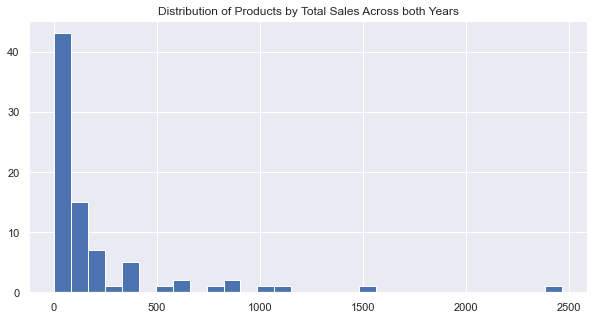

In [36]:
plt.figure(figsize=(10,5))
plt.hist(data=prod_sales,x='total_sales',bins=30)
plt.title("Distribution of Products by Total Sales Across both Years")
plt.show()

Over half of products have recorded less than 100 sales for the duration of data available.

#### Exploring Criteria for picking a subset of products for forecasting

In [37]:
eow_sales = (
    raw.groupby(['upc','end_of_week'])
       .agg(current_week_sales=('quantity_sold',sum),
            current_week_retail=('revenue',sum))
       .reset_index()
)
eow_sales['aur'] = eow_sales['current_week_retail'] / eow_sales['current_week_sales']

In [38]:
px.histogram(eow_sales,x='current_week_sales',height=500,width=800,nbins=40,
            title="Distribution of Products by Weekly Sales")

In a given week, a lot of items sell in small quantities (3 items or less). We might expect a high forecast error.

In [39]:
px.histogram(prod_sales,x='first_week',nbins=20,height=500,width=800,
            title="Distribution of Products by First Available Week")

Products started selling in different weeks throughout the 2 year period. We need to be careful when splitting test vs training data. Testing data set may contain products that was not selling during training period. <br>
Most products started selling in January to June 2021.<br> 
For version 1, we will do forecasts for products from May through end of July.<br> 
We will filter out products that stopped selling before May 2022 (as they have no testing data) and started selling after April 2022 (as they have no training data).

In [40]:
firstWk = prod_sales['first_week'] <= '2022-03-31'
lastWk = prod_sales['last_week'] >= '2022-05-01'
no_of_weeks_sold = prod_sales['weeks_sold'] >= 10

Additionally we will filter out products that were sold less than 10 weeks. <br>
There are products that were selling for a long time but within that period, sales occurred sparsely.
For instance, below product had only 1 week of sales in July 2021 and the next week of sales in June 2022. Since these are prone to high forecast error and there is no direct method to remove products with sparse selling data, we will only keep products if weeks sold (instead of distinct weeks recorded) is at least 10 weeks.

In [41]:
eow_sales[eow_sales['upc']==1570012220].head(3)

,upc,end_of_week,current_week_sales,current_week_retail,aur
29,1570012220,2021-07-04,1.0,3.49,3.49
30,1570012220,2022-06-12,2.0,6.98,3.49
31,1570012220,2022-06-19,6.0,20.94,3.49


In [42]:
eligible_products = prod_sales[firstWk & lastWk & no_of_weeks_sold]

In [43]:
print("Total Products that will be forecasted:",eligible_products['upc'].count())

Total Products that will be forecasted: 30


In [44]:
sales_model_products = eow_sales[(eow_sales['upc'].isin(eligible_products['upc']))].copy()

In [45]:
sales_model_products[sales_model_products['upc']==74236526445].iloc[10:16,]

,upc,end_of_week,current_week_sales,current_week_retail,aur
1719,74236526445,2021-03-28,6.0,41.94,6.99
1720,74236526445,2021-04-04,5.0,34.95,6.99
1721,74236526445,2021-05-23,6.0,41.94,6.99
1722,74236526445,2021-05-30,12.0,83.88,6.99
1723,74236526445,2021-06-06,10.0,69.90,6.99
1724,74236526445,2021-06-13,9.0,62.91,6.99


We don't have sales data at the product level for certain weeks. Above product (UPC = 74236526445) has no data from April 5th until May 23rd. <br>
For version 1 of the model, I will add the missing weeks and fill them with 0. I plan to add lag values as additional features, so it is important to not have gaps in missing weeks.

In [46]:
start = eligible_products['first_week'].min()
end = eligible_products['last_week'].max()

distinct_eop_dates = pd.date_range(start=start,end=end,freq='7D')
distinct_upc = eligible_products['upc'].unique()

In [47]:
all_combinations = pd.DataFrame(list(product(distinct_eop_dates, distinct_upc)), columns=['end_of_week', 'upc'])

date_prod_combo = all_combinations.merge(sales_model_products,on=['upc','end_of_week'],how='left')

In [48]:
date_prod_combo[date_prod_combo['upc']==74236526445].iloc[12:16,]

,end_of_week,upc,current_week_sales,current_week_retail,aur
382,2021-03-28,74236526445,6.0,41.94,6.99
412,2021-04-04,74236526445,5.0,34.95,6.99
442,2021-04-11,74236526445,NaN,NaN,NaN
472,2021-04-18,74236526445,NaN,NaN,NaN


Now we remove any extra weeks we added and fill missing values with 0.

In [49]:
model_data = date_prod_combo.merge(prod_sales[['upc','first_week','last_week']],on=['upc'],how='inner')

In [50]:
model_data = model_data.drop(model_data[model_data.end_of_week < model_data.first_week].index)
model_data = model_data.drop(model_data[model_data.end_of_week > model_data.last_week].index)

In [51]:
model_data.fillna(0,inplace=True)

In [52]:
model_data.reset_index(drop=True, inplace=True)

Add date attributes to our set of data that will be forecasted.

In [53]:
def add_month_year_week(df):
    df['month'] = df['end_of_week'].dt.month
    df['year'] = df['end_of_week'].dt.year
    df['week'] = df['end_of_week'].dt.isocalendar().week
    
    return df

In [54]:
model_data = add_month_year_week(model_data)

In [55]:
def update_end_weeks(cols):

    year = cols[0]
    week = cols[1]
    
    if year == 2022 and week ==52:
        return 0
    elif year == 2021 and week ==53:
        return 0
    else:
        return week

In [56]:
model_data['week'] = model_data[['year','week']].apply(update_end_weeks,axis=1)

In [57]:
assert model_data[model_data['end_of_week']=='2021-01-03']['week'].unique()[0] == 0

In [58]:
def create_lag_columns(df):
    
    for i in range(1,5):
        df["lag_{}".format(i)] = df.groupby('upc')['current_week_sales'].shift(i)
        
    return df

In [59]:
model_data = create_lag_columns(model_data)

In [60]:
model_data['rolling_4wk_mean'] = model_data.groupby('upc')['current_week_sales'].rolling(4).mean().reset_index(0,drop=True)
model_data['rolling_4wk_std'] = model_data.groupby('upc')['current_week_sales'].rolling(4).std().round(3).reset_index(0,drop=True)


In [61]:
model_data.head()

,end_of_week,upc,current_week_sales,current_week_retail,aur,first_week,last_week,month,year,week,lag_1,lag_2,lag_3,lag_4,rolling_4wk_mean,rolling_4wk_std
0,2021-06-13,1570014801,2.0,4.98,2.49,2021-06-13,2022-10-09,6,2021,23,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-20,1570014801,15.0,37.35,2.49,2021-06-13,2022-10-09,6,2021,24,2.0,NaN,NaN,NaN,NaN,NaN
2,2021-06-27,1570014801,21.0,52.29,2.49,2021-06-13,2022-10-09,6,2021,25,15.0,2.0,NaN,NaN,NaN,NaN
3,2021-07-04,1570014801,15.0,37.35,2.49,2021-06-13,2022-10-09,7,2021,26,21.0,15.0,2.0,NaN,13.25,8.016
4,2021-07-11,1570014801,19.0,47.31,2.49,2021-06-13,2022-10-09,7,2021,27,15.0,21.0,15.0,2.0,17.50,3.000


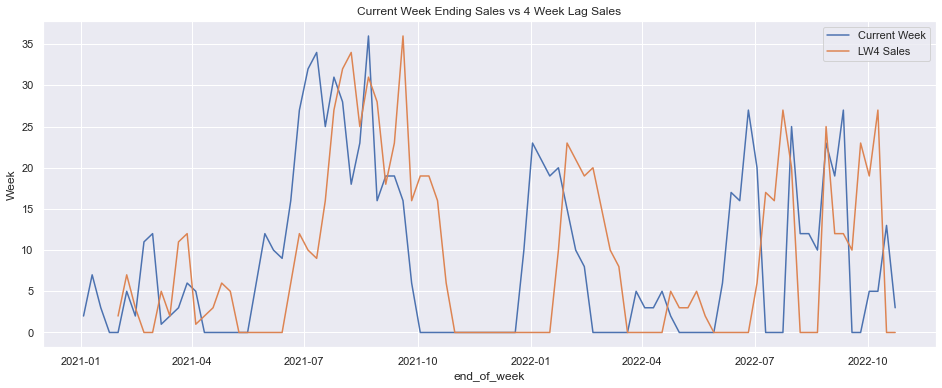

In [62]:
plt.figure(figsize=(16,6))
sns.lineplot(model_data[model_data['upc']==74236526445],x='end_of_week',y='current_week_sales',label='Current Week')
#sns.lineplot(model_data[model_data['upc']==74236526445],x='end_of_week',y='lag_1',label='LW Sales')
sns.lineplot(model_data[model_data['upc']==74236526445],x='end_of_week',y='lag_4',label='LW4 Sales')
#sns.lineplot(model_data[model_data['upc']==74236526445],x='end_of_week',y='rolling_4wk_mean',label='Rolling 4 Wk Mean')
plt.title("Current Week Ending Sales vs 4 Week Lag Sales")
plt.ylabel("Sales Units")
plt.ylabel("Week")
plt.show()

In [63]:
px.scatter(model_data,x='current_week_sales',y='rolling_4wk_mean',title="Rolling 4 Week Mean vs Current Week Sales")

Since there is a high correlation between current week sales and rolling 4 week mean, we will use the base method as simple moving average.

In [64]:
train_test_split = '2022-05-01'
test_end_cutoff = '2022-08-31'
train = model_data[model_data['end_of_week']<=train_test_split].copy()
test = model_data[(model_data['end_of_week']>train_test_split) & (model_data['end_of_week']<=test_end_cutoff)].copy()

In [65]:
model_data.head(3)

,end_of_week,upc,current_week_sales,current_week_retail,aur,first_week,last_week,month,year,week,lag_1,lag_2,lag_3,lag_4,rolling_4wk_mean,rolling_4wk_std
0,2021-06-13,1570014801,2.0,4.98,2.49,2021-06-13,2022-10-09,6,2021,23,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-20,1570014801,15.0,37.35,2.49,2021-06-13,2022-10-09,6,2021,24,2.0,NaN,NaN,NaN,NaN,NaN
2,2021-06-27,1570014801,21.0,52.29,2.49,2021-06-13,2022-10-09,6,2021,25,15.0,2.0,NaN,NaN,NaN,NaN


### Base model 

Here we make predictions using a rolling 4 week average.

In [66]:
test[['end_of_week','upc','current_week_sales','rolling_4wk_mean']].head()

,end_of_week,upc,current_week_sales,rolling_4wk_mean
47,2022-05-08,1570014801,7.0,9.00
48,2022-05-15,1570014801,21.0,12.50
49,2022-05-22,1570014801,19.0,15.00
50,2022-05-29,1570014801,19.0,16.50
51,2022-06-05,1570014801,16.0,18.75


In [67]:
list_of_products = test['upc'].unique()
error = dict()

for prod in list_of_products:
    y_true = test[test['upc']==prod]['current_week_sales']
    y_pred = test[test['upc']==prod]['rolling_4wk_mean']
    
    mse = metrics.mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    
    error[prod] = rmse

In [68]:
base_model = pd.DataFrame(data=error.items(),columns=['upc','rmse'])

In [69]:
print("Overall RMSE: {:0.2f}".format(np.mean(base_model['rmse'])))

Overall RMSE: 3.52


In general, model predicted weekly sales to be about 3.5 away from actuals.

In [70]:
train.isnull().sum()

end_of_week              0
upc                      0
current_week_sales       0
current_week_retail      0
aur                      0
first_week               0
last_week                0
month                    0
year                     0
week                     0
lag_1                   30
lag_2                   60
lag_3                   90
lag_4                  120
rolling_4wk_mean        90
rolling_4wk_std         90
dtype: int64

In [71]:
test.isnull().sum()

end_of_week            0
upc                    0
current_week_sales     0
current_week_retail    0
aur                    0
first_week             0
last_week              0
month                  0
year                   0
week                   0
lag_1                  0
lag_2                  0
lag_3                  0
lag_4                  0
rolling_4wk_mean       0
rolling_4wk_std        0
dtype: int64

In [72]:
train = train.fillna(0)

#### Model - Random Forest Regressor

In [73]:
features = ['upc', 'current_week_retail','aur', 'month', 'year', 'week', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'rolling_4wk_mean', 'rolling_4wk_std']

In [74]:
X_train = train[features]
y_train = train['current_week_sales']

In [75]:
X_test = test[features]
y_test = test['current_week_sales']

In [76]:
X_train.head()

,upc,current_week_retail,aur,month,year,week,lag_1,lag_2,lag_3,lag_4,rolling_4wk_mean,rolling_4wk_std
0,1570014801,4.98,2.49,6,2021,23,0.0,0.0,0.0,0.0,0.00,0.000
1,1570014801,37.35,2.49,6,2021,24,2.0,0.0,0.0,0.0,0.00,0.000
2,1570014801,52.29,2.49,6,2021,25,15.0,2.0,0.0,0.0,0.00,0.000
3,1570014801,37.35,2.49,7,2021,26,21.0,15.0,2.0,0.0,13.25,8.016
4,1570014801,47.31,2.49,7,2021,27,15.0,21.0,15.0,2.0,17.50,3.000


In [77]:
random_forest = RandomForestRegressor(n_estimators=1000,random_state=1,criterion='squared_error')

In [78]:
random_forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

In [79]:
y_pred = random_forest.predict(X_test)

In [80]:
y_pred[:5]

array([ 6.887, 16.985, 17.718, 18.045, 17.493])

In [81]:
#np.sqrt(metrics.mean_squared_error(y_test,y_pred))

In [82]:
test['pred_sales'] = y_pred

In [83]:
list_of_products = test['upc'].unique()
error = dict()

for prod in list_of_products:
    y_true = test[test['upc']==prod]['current_week_sales']
    y_pred = test[test['upc']==prod]['pred_sales']
    
    mse = metrics.mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    
    error[prod] = rmse

In [84]:
random_forest = pd.DataFrame(error.items(),columns=['upc','rmse'])

In [85]:
print("Overall RMSE: {:0.2f}".format(np.mean(random_forest['rmse'])))

Overall RMSE: 1.19


For version 1, we will proceed with Random Forest Regressor as it gives a better accuracy.